In [2]:
pip install torch torch-geometric scikit-learn pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [4]:
!pip install --upgrade torch-geometric

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import f1_score, precision_score, recall_score

# Load and preprocess data
df = pd.read_csv("manufacturing_test_data.csv")
df['Timestamps'] = pd.to_datetime(df['Timestamps'], format='%H:%M:%S')

# Task phase assignment
task_ranges = [
    ('17:58:07', '17:59:47'),  # Task 1
    ('17:59:47', '18:01:27'),  # Task 2
    ('18:01:27', '18:02:59')   # Task 3
]
df['Task_Phase'] = 0
for idx, (start, end) in enumerate(task_ranges, 1):
    mask = (df['Timestamps'] >= pd.to_datetime(start)) & (df['Timestamps'] <= pd.to_datetime(end))
    df.loc[mask, 'Task_Phase'] = idx

# Synthetic anomaly injection
np.random.seed(42)
anomaly_mask = np.zeros(len(df), dtype=bool)

# 1. M2 running during Task 1
task1_mask = df['Task_Phase'] == 1
anomaly_indices = df[task1_mask].sample(frac=0.05).index
df.loc[anomaly_indices, 'M2_Status'] = 'Running'
anomaly_mask[anomaly_indices] = True

# 2. M3 stopped during Task 3
task3_mask = df['Task_Phase'] == 3
anomaly_indices = df[task3_mask].sample(frac=0.05).index
df.loc[anomaly_indices, 'M3_Status'] = 'Stopped'
anomaly_mask[anomaly_indices] = True

# Graph construction parameters
window_size = 10  # 10-second temporal window
num_nodes = 3     # M1, M2, M3

def create_graph_components(row):
    """Create node features and edges for a single timestamp"""
    # Node features: [status, workers, expected_status]
    node_features = []
    for machine in ['M1', 'M2', 'M3']:
        status = 1 if row[f'{machine}_Status'] == 'Running' else 0
        workers = row[f'{machine}_Worker_Count'] / 5.0  # Normalized
        expected = 1 if (
            (row['Task_Phase'] == 1 and machine == 'M1') or
            (row['Task_Phase'] == 2 and machine == 'M2') or
            (row['Task_Phase'] == 3 and machine == 'M3')
        ) else 0
        node_features.append([status, workers, expected])

    # Edge connections based on task phase
    if row['Task_Phase'] == 1:
        edge_index = torch.tensor([[0, 0], [1, 2]], dtype=torch.long)  # M1->M2, M1->M3
    elif row['Task_Phase'] == 2:
        edge_index = torch.tensor([[1], [2]], dtype=torch.long)        # M2->M3
    else:
        edge_index = torch.tensor([[], []], dtype=torch.long)          # No edges

    return torch.tensor(node_features, dtype=torch.float), edge_index

# Create temporal sequences
sequences = []
for i in range(len(df) - window_size + 1):
    sequence = []
    for j in range(i, i + window_size):
        row = df.iloc[j]
        node_features, edge_index = create_graph_components(row)
        sequence.append((node_features, edge_index))
    sequences.append(sequence)

# Temporal GNN Model
# ... (keep all previous code until model definition)

class TemporalGNN(nn.Module):
    def __init__(self, node_dim=3, hidden_dim=16, temporal_dim=64):
        super().__init__()
        self.gat = GATConv(node_dim, hidden_dim, heads=2)
        self.transformer = TransformerEncoder(
            TransformerEncoderLayer(
                d_model=hidden_dim*2,
                nhead=2,
                dim_feedforward=64,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=2
        )
        self.decoder = nn.Linear(hidden_dim*2, node_dim * num_nodes)

    def forward(self, seq):
        hidden_states = []
        for node_features, edge_index in seq:
            x = F.relu(self.gat(node_features, edge_index))  # [3, 32]
            graph_embedding = x.mean(dim=0)  # [32]
            hidden_states.append(graph_embedding)

        temporal_input = torch.stack(hidden_states).unsqueeze(0)  # [1, seq_len, 32]
        temporal_out = self.transformer(temporal_input)  # [1, seq_len, 32]
        return self.decoder(temporal_out[:, -1, :]).squeeze(0)  # Output shape [9]

# ... (keep remaining code identical)
# Training setup
model = TemporalGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train-validation split
val_size = int(0.2 * len(sequences))
train_seq = sequences[:-val_size]
val_seq = sequences[-val_size:]

# Training loop
model.train()
for epoch in range(50):
    total_loss = 0
    for seq in train_seq:
        optimizer.zero_grad()

        # Get targets (last step's node features)
        target = seq[-1][0].view(-1)  # Flattened features [3*3=9]

        # Forward pass
        prediction = model(seq)
        loss = criterion(prediction, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_seq):.4f}")

# Validation and threshold calculation
model.eval()
errors = []
with torch.no_grad():
    for seq in val_seq:
        target = seq[-1][0].view(-1)
        prediction = model(seq)
        errors.append(criterion(prediction, target).item())

# Find optimal threshold using validation data
val_anomalies = anomaly_mask[-val_size*window_size:]
precision, recall, thresholds = precision_recall_curve(val_anomalies[:len(errors)], errors)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
threshold = thresholds[optimal_idx]

# Final evaluation
test_errors = []
with torch.no_grad():
    for seq in sequences:
        target = seq[-1][0].view(-1)
        prediction = model(seq)
        test_errors.append(criterion(prediction, target).item())

# Generate predictions
pred_labels = (np.array(test_errors) > threshold).astype(int)
true_labels = anomaly_mask[window_size-1:len(pred_labels)+window_size-1]

# Calculate metrics
print(f"F1 Score: {f1_score(true_labels, pred_labels):.2f}")
print(f"Precision: {precision_score(true_labels, pred_labels):.2f}")
print(f"Recall: {recall_score(true_labels, pred_labels):.2f}")

# Example anomaly inspection
print("\nSample Anomalies:")
for idx in np.where(pred_labels)[0][:5]:
    timestamp = df.iloc[idx + window_size - 1]['Timestamps']
    print(f"At {timestamp}: Error = {test_errors[idx]:.4f}")

Epoch 1, Loss: 0.0656
Epoch 2, Loss: 0.0625
Epoch 3, Loss: 0.0655
Epoch 4, Loss: 0.0641
Epoch 5, Loss: 0.0646
Epoch 6, Loss: 0.0632
Epoch 7, Loss: 0.0614
Epoch 8, Loss: 0.0635
Epoch 9, Loss: 0.0672
Epoch 10, Loss: 0.0677
Epoch 11, Loss: 0.0760
Epoch 12, Loss: 0.0730
Epoch 13, Loss: 0.0734
Epoch 14, Loss: 0.0801
Epoch 15, Loss: 0.0876
Epoch 16, Loss: 0.0817
Epoch 17, Loss: 0.0893
Epoch 18, Loss: 0.0803
Epoch 19, Loss: 0.0909
Epoch 20, Loss: 0.0918
Epoch 21, Loss: 0.1049
Epoch 22, Loss: 0.1081
Epoch 23, Loss: 0.1047
Epoch 24, Loss: 0.1072
Epoch 25, Loss: 0.0955
Epoch 26, Loss: 0.0858
Epoch 27, Loss: 0.1046
Epoch 28, Loss: 0.1116
Epoch 29, Loss: 0.1117
Epoch 30, Loss: 0.1113
Epoch 31, Loss: 0.1112
Epoch 32, Loss: 0.1103
Epoch 33, Loss: 0.1105
Epoch 34, Loss: 0.1016
Epoch 35, Loss: 0.0853
Epoch 36, Loss: 0.1044
Epoch 37, Loss: 0.1075
Epoch 38, Loss: 0.1103
Epoch 39, Loss: 0.1102
Epoch 40, Loss: 0.1110
Epoch 41, Loss: 0.1107
Epoch 42, Loss: 0.1110
Epoch 43, Loss: 0.1111
Epoch 44, Loss: 0.11

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


F1 Score: 0.00
Precision: 0.00
Recall: 0.00

Sample Anomalies:
At 1900-01-01 17:58:16: Error = 0.1305
At 1900-01-01 17:58:17: Error = 0.1328
At 1900-01-01 17:58:18: Error = 0.1328
At 1900-01-01 17:58:19: Error = 0.1201
At 1900-01-01 17:58:20: Error = 0.1185


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


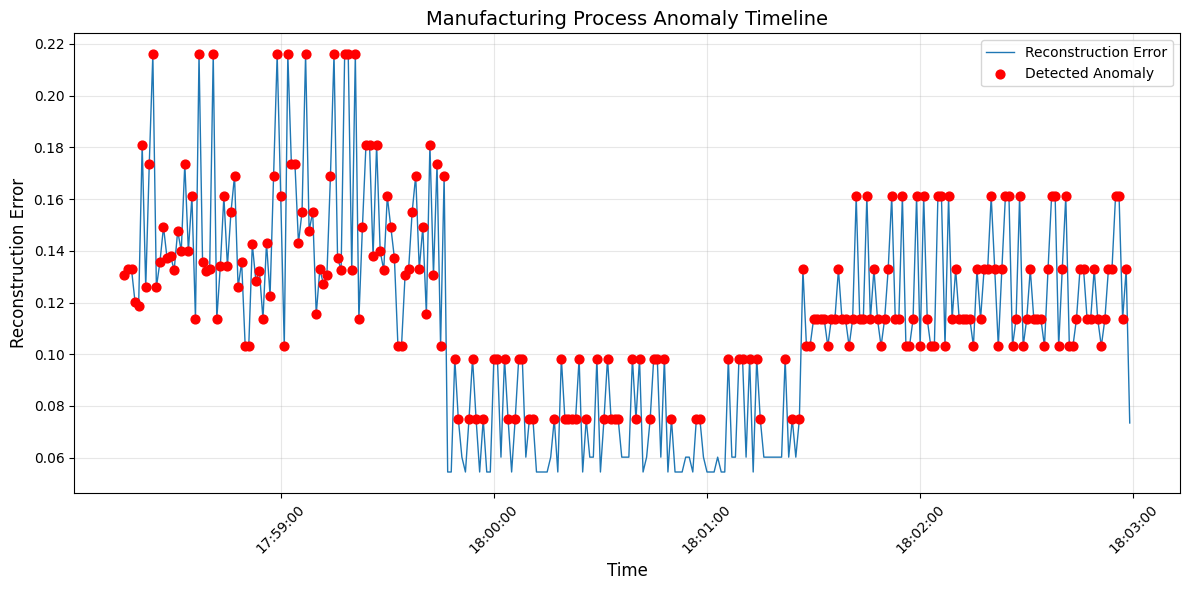

In [15]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# Prepare data
timestamps = df['Timestamps'].iloc[window_size-1:len(pred_labels)+window_size-1]
error_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Error': test_errors,
    'Anomaly': pred_labels
})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(error_df['Timestamp'], error_df['Error'],
        label='Reconstruction Error', linewidth=1)
plt.scatter(error_df[error_df['Anomaly'] == 1]['Timestamp'],
          error_df[error_df['Anomaly'] == 1]['Error'],
          color='red', s=40, zorder=3, label='Detected Anomaly')

# Formatting
plt.title("Manufacturing Process Anomaly Timeline", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Reconstruction Error", fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()